In [26]:
# Imports
import rasterio
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from rasterio.transform import AffineTransformer, Affine
from rasterio.profiles import DefaultGTiffProfile
from rasterio.crs import CRS
from pyproj.database import query_utm_crs_info
from massimal import georeferencing
from rasterio.rio import edit_info
import numpy.typing as npt

In [2]:
# Paths
image_dir = Path.cwd() / 'ExampleImages' 
image_path = image_dir / 'Juvika_June2022_Pika_L_12.png'
#wld_file_path = image_dir / 'Juvika_June2022_Pika_L_12.wld'
lcf_file_path = image_dir / 'Juvika_June2022_Pika_L_12.lcf'
times_file_path = image_dir / 'Juvika_June2022_Pika_L_12.bil.times'


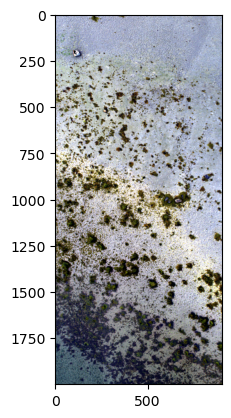

In [3]:
# Load image 
image = imread(image_path)
_ = plt.imshow(image)

In [9]:
lcf_data = georeferencing.read_lcf_file(lcf_file_path)
image_times = georeferencing.read_times_file(times_file_path)
framerate = 1/np.mean(np.diff(image_times))

# Calculate transform parameters
affine_transform_parameters, utm_epsg = georeferencing.calculate_pushbroom_imager_transform(
    lcf_data['time'],
    lcf_data['longitude'],
    lcf_data['latitude'],
    lcf_data['altitude'],
    framerate,
    use_world_file_ordering=False,
    pitch_offset = np.mean(lcf_data['pitch']),
    roll_offset = np.mean(lcf_data['roll']),
    ground_altitude=-10)

In [10]:
# Load affine transform coefficients from text file
# affine_transform_parameters = np.loadtxt(wld_file_path)
# a,d,b,e,c,f = affine_transform_parameters
# print(affine_transform_parameters)

In [11]:
# Define and test transformer
# transform = Affine(a,b,c,d,e,f)
transform = Affine(*affine_transform_parameters)
transformer = AffineTransformer(transform)
transformer.xy(0, 0)

(500204.33867634373, 7455411.763865415)

In [17]:
transform

Affine(0.025746833032614692, 0.025290239927096874, 500204.3131578073,
       0.024024646518708413, -0.027103149436586788, 7455411.765404667)

In [12]:
# Create GeoTIFF profile and update with current parameters
profile = DefaultGTiffProfile()
utm33n_epsg = 32633
profile.update(height = image.shape[0], 
               width = image.shape[1],
               count = image.shape[2], 
               dtype=str(image.dtype),
               crs= CRS.from_epsg(utm33n_epsg),
               transform=transform)
print(profile)

{'driver': 'GTiff', 'interleave': 'band', 'tiled': True, 'blockxsize': 256, 'blockysize': 256, 'compress': 'lzw', 'nodata': 0, 'dtype': 'uint8', 'height': 2000, 'width': 900, 'count': 3, 'crs': CRS.from_epsg(32633), 'transform': Affine(0.025746833032614692, 0.025290239927096874, 500204.3131578073,
       0.024024646518708413, -0.027103149436586788, 7455411.765404667)}


In [13]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write image with context manager
    with rasterio.open(image_dir / (image_path.stem +'.tif'), 'w', **profile) as dst:
        dst.write(np.moveaxis(image,2,0)) # Move bands from 3rd to 1st axis (required)

In [22]:
# Edit transform directly in GeoTiff (shift slightly in x- and y-dir)
# Note: Uses the a,b,c,d,e,f ordering, same as "Affine" object
!rio edit-info --transform "[0.025746, 0.025290, 500199.31, 0.02402464, -0.02710314, 7455416.76]" ExampleImages/Juvika_June2022_Pika_L_12.tif 

In [36]:
def save_geotiff_with_affine_transform(
        image: npt.NDArray,
        crs_str: str,
        geotiff_path,
        affine_transform: tuple = None,
        world_file_path = None,
        channels_already_first: bool = False) -> None:
    """ Save georeferenced image (single- or multiband) as GeoTIFF using affine transform
    
    # Input arguments:
    image:
        2D or 3D NumPy array
    crs_str:
        Coordinate reference system mathcing the affine transform used.
        String accepted by the rasterio.crs.CRS.from_string() method
        (https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html#rasterio.crs.CRS.from_string)
        EPSG, PROJ, and WKT strings are accepted.
        Example: "EPSG:32633"
    geotiff_path:
        File path for the GeoTIFF file to be written.
        
    # Keyword arguments:
    affine_transform:
        A 6-parameter transform for translation, scaling and rotation of 
        the image. Example (for UTM 33N): 
        (0.025746, 0.025290, 500199.3122, 0.02402464, -0.02710314, 7455416.7654)
        The ordering corresponds to (A,B,C,D,E,F).
        Note that this is not the same ordering as in the world file.
        If both affine_transform and world_file_path are specified, or if none
        of them are specified, an error is thrown.
    world_file_path:
        Path to text file containing exactly 6 lines with a single
        numer on each line. See https://en.wikipedia.org/wiki/World_file
        for specification. Note that the ordering of the lines in the file
        corresponds to (A,D,B,E,C,F)
    channels_already_first:
        Flag indicating that the image is organized "channels-first".
        This is the format required by rasterio / GDAL when writing GeoTIFFs.
        If False (default), channels in image are assumed to be last 
        (shape (nrows,ncols,nchannels)), and the last axis will be moved
        to first position before the file is written.    
    """

    # Check affine transform input
    if (affine_transform is None): 
        if (world_file_path is None):
            raise ValueError("Please specify either affine_transform or world_file_path")
        else:
            affine_transform = np.loadtxt(world_file_path)
    elif (world_file_path is not None):
            raise ValueError("Please specify either affine_transform or world_file_path (not both)")

    # Create affine transform object
    transform = Affine(*affine_transform)

    # Convert 2D array to 3D (for unified processing)
    if image.ndim < 3:
         image = np.atleast_3d(image)
         channels_already_first = False

    # Ensure "channels-first" array, as required by rasterio/GDAL
    if not channels_already_first:
        image = np.moveaxis(image,2,0)

    # Create default GeoTIFF profile and update with current parameters
    profile = DefaultGTiffProfile()
    profile.update(height = image.shape[1], 
                   width = image.shape[2],
                   count = image.shape[0], 
                   dtype = str(image.dtype),
                   crs = CRS.from_str(crs_str),
                   transform = transform)
    
    # Register GDAL format drivers and configuration options with a context manager.
    with rasterio.Env():
        # Write image with context manager
        with rasterio.open(geotiff_path, 'w', **profile) as dst:
            dst.write(image) 

In [27]:
tmp = npt.NDArray

In [31]:
image.ndim

3

In [29]:
raise ValueError('TestMessage')

ValueError: TestMessage

In [32]:
image = np.zeros((100,100))

In [33]:
image_3d = np.atleast_3d(image)

In [34]:
image.shape

(100, 100)

In [35]:
image_3d.shape

(100, 100, 1)